In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import warnings;
warnings.filterwarnings('ignore');

### Dataset

In [16]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Himawan Putra\Documents\GitHub\Deep-Learning-Bank-Customer-Complaint-Analysis\01_prediksi\result\01_date_preprocessing_result.csv", sep=",")
df.head()


,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking,Complaint_tokenized_text
0,0,purchase order day shipping amount receive pro...,1705,True,False,False,False,False,"[['purchase', 'order', 'day', 'shipping', 'amo..."
1,1,forwarded message date tue subject please inve...,904,True,False,False,False,False,"[['forwarded', 'message', 'date', 'tue', 'subj..."
2,2,forwarded message cc sent friday pdt subject f...,1230,False,False,False,False,True,"[['forwarded', 'message', 'cc', 'sent', 'frida..."
3,3,payment history missing credit report speciali...,903,False,True,False,False,False,"[['payment', 'history', 'missing', 'credit', '..."
4,4,payment history missing credit report made mis...,851,False,True,False,False,False,"[['payment', 'history', 'missing', 'credit', '..."


### Splitting Data

In [17]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)
tokenizer.fit_on_texts(df['narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 45959 unique tokens.


In [18]:
X = tokenizer.texts_to_sequences(df['narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (162411, 250)


In [19]:
y = np.argmax(df[['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']].values, axis=1)

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2 , random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [21]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(103942, 250) (103942,)
(32483, 250) (32483,)


### Modeling

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout, Attention, MultiHeadAttention, Flatten,  Embedding, LSTM, Dense, GlobalMaxPooling1D, LayerNormalization, GlobalAveragePooling1D, Add

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, MultiHeadAttention, Dense, Add, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Model parameters
num_heads = 4
num_units = 64
dropout_rate = 0.4

num_units_1 = 32
num_units_2 = 16
dropout_rate_1 = 0.1

# Input parameters
MAX_SEQUENCE_LENGTH = 250
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100

# Model definition
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)

# First LSTM layer
lstm_layer1 = LSTM(num_units_1, return_sequences=True)(embedding_layer)

# First MultiHeadAttention layer
attention_output1 = MultiHeadAttention(num_heads=num_heads, key_dim=num_units_1)(lstm_layer1, lstm_layer1, lstm_layer1)
attention_output1 = Dense(num_units_1)(attention_output1)
add_layer1 = Add()([lstm_layer1, attention_output1])
norm_layer1 = LayerNormalization(epsilon=1e-6)(add_layer1)

# Dropout for regularization
dropout_layer1 = Dropout(dropout_rate_1)(norm_layer1)

# Second LSTM layer
lstm_layer2 = LSTM(num_units_2, return_sequences=True)(dropout_layer1)

# Second MultiHeadAttention layer
attention_output2 = MultiHeadAttention(num_heads=num_heads, key_dim=num_units_2)(lstm_layer2, lstm_layer2, lstm_layer2)
attention_output2 = Dense(num_units_2)(attention_output2)
add_layer2 = Add()([lstm_layer2, attention_output2])
norm_layer2 = LayerNormalization(epsilon=1e-6)(add_layer2)

# Dropout for regularization
dropout_layer2 = Dropout(dropout_rate_1)(norm_layer2)

# Global average pooling
global_avg_pooling = GlobalAveragePooling1D()(dropout_layer2)

# Dense output layer
output_layer = Dense(5, activation='softmax')(global_avg_pooling)

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 250, 100)  │  2,000,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 250, 32)   │     17,024 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 32)   │     16,800 │ lstm_4[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lstm_4[0][0],     │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 250, 32)   │      1,056 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 250, 32)   │          0 │ lstm_4[0][0],     │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 32)   │         64 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 250, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 250, 16)   │      3,136 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 16)   │      4,304 │ lstm_5[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lstm_5[0][0],     │
│                     │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 250, 16)   │        272 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 250, 16)   │          0 │ lstm_5[0][0],     │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 16)   │         32 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 250, 16)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ dropout_11[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 5)         │         85 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,042,773 (7.79 MB)

 Trainable params: 2,042,773 (7.79 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [31]:
num_epochs = 20
batch_size = 256
## For early stopping to ensure it doesnt overfit
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    epochs=num_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/20
  6/407 ━━━━━━━━━━━━━━━━━━━━ 30:28 5s/step - accuracy: 0.3605 - loss: 1.8683

In [ ]:
# Ambil loss dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

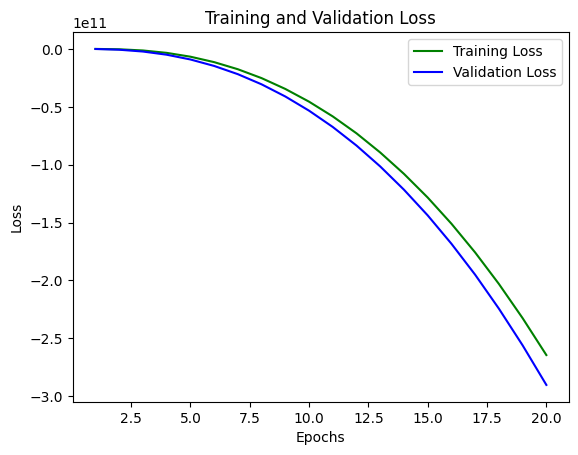

In [ ]:
# Plot kurva loss
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Mengevaluasi kinerja model menggunakan data validasi
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Model Validation Accuracy:", val_acc)

813/813 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5585 - loss: -298744152064.0000
Model Validation Accuracy: 0.5577234029769897


### Evaluating the Model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test,y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5624 - loss: -289503608832.0000
Test loss: -281451495424.0
Test accuracy: 0.5628790259361267
